In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets --quiet
!pip install -U sentence-transformers --quiet
!pip install fasttext

In [ ]:
from datasets import load_dataset
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from transformers import BertTokenizer,BertTokenizerFast,BertModel, BertConfig
import torch
import torch.nn.functional as F
import numpy as np

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import  train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import fasttext

### DATASET

In [ ]:
wiki_datasets = load_dataset("OxAISH-AL-LLM/wiki_toxic")

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

In [ ]:
wiki_train = wiki_datasets['train'].to_pandas()
wiki_validation = wiki_datasets['validation'].to_pandas()
wiki_test = wiki_datasets['test'].to_pandas()

In [ ]:
# Check NAN or Null values
conteggio_null_train = wiki_train.isnull().sum()
conteggio_null_validation = wiki_validation.isnull().sum()
conteggio_null_test = wiki_test.isnull().sum()

 Create a balanced dataset with all the hate (toxic) comments from the 3 splits

In [ ]:
# Get hate comments from the 3 splits
hate_train = wiki_train[wiki_train['label'] == 1]
hate_validation = wiki_validation[wiki_validation['label'] == 1]
hate_test = wiki_test[wiki_test['label'] == 1]
# Put all together
hate = pd.concat([hate_train, hate_validation, hate_test], ignore_index=True)
# Select same number of 'non-hate' comments and create the final df
non_hate = hate_train = wiki_train[wiki_train['label'] == 0][:len(hate)]
wiki_df_base = pd.concat([hate, non_hate], ignore_index=True)
# Shuffle of df
wiki_df_base = wiki_df_base.sample(frac=1).reset_index(drop=True)

### PRE-PROCESSING

In [ ]:
def preprocessing(dataset, remove_stopwords = True, bert_tokenization = False, text_column = 'comment_text'):
    # Removing links
    dataset[text_column] = dataset[text_column].apply(lambda s: ' '.join(re.sub("(w+://S+)", " ", s).split()))

    # removed numbers
    dataset[text_column].replace('d+', '', regex=True, inplace=True)

    # Removing punctuation
    dataset[text_column] = dataset[text_column].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))


    # Tokenization
    if bert_tokenization: # tokenization using Bert tokenizer
        tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased", do_lower_case=True)
        dataset[text_column] = dataset[text_column].apply(lambda x: tokenizer.tokenize(x))
    else:
        dataset[text_column] = dataset[text_column].apply(lambda x: word_tokenize(x))

    # To lowercase
    dataset[text_column] = dataset[text_column].apply(lambda x: [word.lower() for word in x])

    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) #- set(['not', 'no'])
        dataset[text_column] = dataset[text_column].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    dataset[text_column] = dataset[text_column].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Re join in string
    dataset[text_column] = dataset[text_column].apply(lambda x: " ".join(x))
    return dataset


In [ ]:
wiki_df = preprocessing(wiki_df_base)
wiki_df_withStopwords = preprocessing(wiki_df_base, remove_stopwords = False)

In [ ]:
wiki_df_withStopwords.to_csv("/content/drive/MyDrive/Data science/NLP/Alex/wiki_toxic.csv")

### EMBEDDING

#### Functions

In [ ]:
def tf_idf_withPCA(dataset, text_column='comment_text'):
    # Apply TF-Idf
    tfidf_embedding = TfidfVectorizer(max_features=20000).fit_transform(dataset[text_column])
    print(tfidf_embedding.shape)
    # Dimensionality reduction using PCA
    pca = PCA(n_components=100)  # set the desired number of component
    tfidf_pca = pca.fit_transform(tfidf_embedding.toarray())

    # Creating a DataFrame with Reduced Embedding
    pca_df = pd.DataFrame(tfidf_pca, columns=['pca_' + str(i) for i in range(tfidf_pca.shape[1])])
    return pd.concat([dataset ,pca_df], axis=1)


In [ ]:
def get_BertEmbedding(dataset, text_column='comment_text'):
    # Load model from HuggingFace Hub
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
    model = BertModel.from_pretrained("bert-base-cased")

    wiki_comments = dataset[text_column]
    embeddings = list()
    i=0
    for comment in wiki_comments:
        print(i)
        # Tokenize sentences
        encoded_input = tokenizer.encode_plus(
                            comment,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 32,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt'     # Return pytorch tensors.
                    )
        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)
            pooled_output = model_output[1]
        i+=1
        embeddings.append(pooled_output)
    return embeddings


In [ ]:
def get_FastTextEmbedding(dataset, text_column='comment_text'):
    # Pre-trained english word vectors trained on wikipedia
    model = fasttext.load_model('/content/drive/MyDrive/NLP/wiki_en.bin')

    wiki_comments = dataset[text_column]
    fastText_embeddings = list()
    i=0
    for comment in wiki_comments:
        embedding = model.get_sentence_vector(comment)
        fastText_embeddings.append(embedding)
        print(i)
        i+=1
    return fastText_embeddings

In [ ]:
# Transform tensor in list
def tensor_to_list(row):
    tensor = row['bert_embedding']
    return pd.Series(tensor.tolist())

#### Embedding part

In [ ]:
# TFIDF embedding
wiki_tfidf = tf_idf_withPCA(wiki_df)
# BERT embedding
wiki_bertEmbedding = get_BertEmbedding(wiki_df)
# FastText embedding
fastText_embeddings = get_FastTextEmbedding(wiki_df)
# Put all in the same df
wiki_tfidf['bert_embedding'] = wiki_bertEmbedding
wiki_embedded['fastText_embeddings'] = fastText_embeddings
# Save it on a pickle file
wiki_embedded.to_pickle('/content/drive/MyDrive/NLP/wiki_emb_withFastText')

In [ ]:
# We can recover the Dataset with TF-idf and Bert embeddings from the file, saving time
wiki_embedded_fastText = pd.read_pickle('/content/drive/MyDrive/NLP/wiki_emb_withFastText')

In [ ]:
wiki_embedded_fastText.drop(['id', 'comment_text'], axis=1, inplace=True)

In [ ]:
# Apply the function to dataset rows
wiki_embedded_fastText['bert_embedding'] = wiki_embedded_fastText.apply(lambda row: tensor_to_list(row), axis=1)

In [ ]:
# Split embedding vectors in single columns
# BERT
wiki_embedded_fastText[['embeddBert_val_' + str(i) for i in range(len(wiki_embedded_fastText.iloc[0]['bert_embedding']))]] = \
    pd.DataFrame(wiki_embedded_fastText['bert_embedding'].values.tolist(), index= wiki_embedded_fastText.index)

wiki_embedded_fastText.drop(['bert_embedding'], axis=1, inplace=True)

# FASTTEXT
wiki_embedded_fastText[['embedFastText_val_' + str(i) for i in range(len(wiki_embedded_fastText.iloc[0]['fastText_embeddings']))]] = \
    pd.DataFrame(wiki_embedded_fastText['fastText_embeddings'].values.tolist(), index= wiki_embedded_fastText.index)

wiki_embedded_fastText.drop(['fastText_embeddings'], axis=1, inplace=True)

### PREDICTION XGboost

In [ ]:
X = wiki_embedded_fastText.loc[:, wiki_embedded_fastText.columns != 'label']
y = wiki_embedded_fastText['label']
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, stratify=y_testval, random_state=1234)

In [ ]:
classifier_xgb = XGBClassifier().fit(X_train, y_train)
pred_xgb = classifier_xgb.predict(X_test)
cm = confusion_matrix(y_test, pred_xgb)
accuracy = accuracy_score(y_test, pred_xgb)

In [ ]:
accuracy

0.8838451268357811

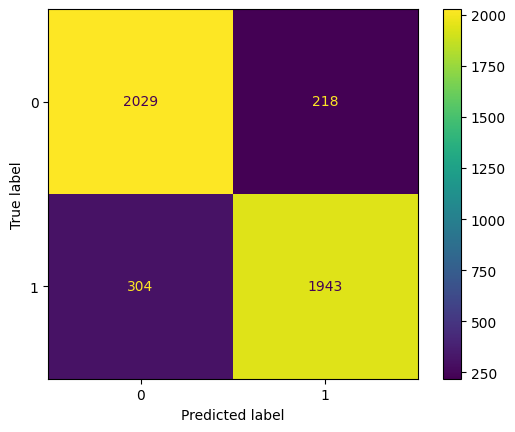

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2247
           1       0.90      0.86      0.88      2247

    accuracy                           0.88      4494
   macro avg       0.88      0.88      0.88      4494
weighted avg       0.88      0.88      0.88      4494



Hyperparameters Optimization

In [ ]:
params_grid = {'gamma': [0,0.3,0.5], #def 0
              'learning_rate': [0.2, 0.3, 0.4], # def 0.3
              'max_depth': [4,6,8], # def 6
              #'n_estimators': [50,65,80,100,115,130,150],
              #'reg_alpha': [0,0.1,0.3,0.5],
              #'reg_lambda': [0,0.1,0.3,0.5],
              #'min_child_weight': [0.5, 1]
              #'subsample': [0.6, 0.8, 1.0],
              #'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier()
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

grid_search = GridSearchCV(xgb, param_grid=params_grid, scoring='accuracy', n_jobs=4, cv=skf.split(X_val,y_val))

grid_search.fit(X_val, y_val)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f3f682537d0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'gamma': [0, 0.3, 0.5],
                         'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [4, 6, 8]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6}

In [ ]:
grid_search.best_score_

0.8534712950600801

The hyperparameters tuning requires a lot of time to be computed, we did some try but without finding any combination that improves preformances.

### OTHER DATASETS

#### Automated Hate Speech Detection Dataset


##### Dataset & pre-processing

In [ ]:
automated_dataset = pd.read_csv('/content/drive/MyDrive/Data science/NLP/dataset/hate_speech_offensiveWithHatespeech/labeled_data.csv')

In [ ]:
automated_dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
sameval_dataset = preprocessing(dataset=sameval_dataset, text_column="tweet")

##### Embedding

In [ ]:
automated_dataset_embedd = tf_idf_withPCA(dataset=automated_dataset, text_column="tweet")
automated_bertEmbedding = get_BertEmbedding(dataset=automated_dataset, text_column="tweet")
automated_dataset_embedd['bert_embedding'] = automated_bertEmbedding
automated_fastTextEmbedding = get_FastTextEmbedding(dataset=automated_dataset, text_column="tweet")
automated_dataset_embedd['fastText_embeddings'] = automated_fastTextEmbedding

In [ ]:
automated_dataset_embedd.drop(['Unnamed: 0',	'count', 'hate_speech',	'offensive_language', 'neither', 'tweet'], axis=1, inplace=True)

In [ ]:
automated_dataset_embedd['bert_embedding'] = automated_dataset_embedd.apply(lambda row: tensor_to_list(row), axis=1)

In [ ]:
# Split vectors embeddings in single columns
# BERT
automated_dataset_embedd[['embeddBert_val_' + str(i) for i in range(len(automated_dataset_embedd.iloc[0]['bert_embedding']))]] = \
    pd.DataFrame(automated_dataset_embedd['bert_embedding'].values.tolist(), index= automated_dataset_embedd.index)

automated_dataset_embedd.drop(['bert_embedding'], axis=1, inplace=True)

# FASTTEXT
automated_dataset_embedd[['embedFastText_val_' + str(i) for i in range(len(automated_dataset_embedd.iloc[0]['fastText_embeddings']))]] = \
    pd.DataFrame(automated_dataset_embedd['fastText_embeddings'].values.tolist(), index= automated_dataset_embedd.index)

automated_dataset_embedd.drop(['fastText_embeddings'], axis=1, inplace=True)

In [ ]:
automated_dataset_embedd

,class,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,embedFastText_val_290,embedFastText_val_291,embedFastText_val_292,embedFastText_val_293,embedFastText_val_294,embedFastText_val_295,embedFastText_val_296,embedFastText_val_297,embedFastText_val_298,embedFastText_val_299
0,2,-0.034068,-0.065989,-0.068252,0.067210,-0.015660,-0.060597,0.051520,-0.033513,0.032304,...,0.016910,-0.001471,0.004102,-0.003085,-0.007088,-0.022169,-0.051006,0.036561,0.063015,0.012150
1,1,-0.089154,0.052109,-0.012100,0.066502,0.026041,0.004552,-0.003941,0.017331,0.004941,...,0.015960,-0.022335,0.013975,0.014835,-0.005028,-0.006781,-0.041480,0.012148,0.041751,0.026825
2,1,0.053785,0.033583,0.032896,0.104403,-0.048080,-0.033848,0.131889,0.075119,0.129740,...,-0.011408,0.002762,0.038921,-0.011048,0.001523,-0.022893,-0.029723,0.014669,0.049743,0.015202
3,1,-0.010446,-0.032599,0.012146,0.018771,0.242228,-0.174908,0.085803,0.026023,0.020478,...,0.013420,-0.011779,0.035676,0.015511,0.024414,-0.035530,-0.058974,0.040173,0.045009,0.004617
4,1,0.039210,0.003667,-0.011966,0.055267,-0.005767,-0.003348,0.001332,-0.009512,0.008461,...,-0.032337,0.031126,0.019825,0.001107,0.004684,-0.037067,-0.032090,0.025116,0.050649,0.012768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,1,-0.029461,-0.075794,-0.066247,-0.006076,-0.025891,-0.020763,-0.000620,-0.013803,0.019255,...,0.017034,0.007309,0.016243,-0.003989,0.035037,-0.030092,-0.032169,0.038671,0.034965,0.025353
24779,2,-0.017262,-0.043393,-0.040625,-0.019131,-0.017316,0.003198,-0.015907,0.001943,-0.007966,...,0.019415,-0.003786,0.014292,-0.023048,-0.003926,-0.013197,-0.021056,0.062968,0.046857,0.003827
24780,1,-0.016956,-0.021690,0.038817,-0.099319,0.098831,-0.063559,-0.041898,-0.026626,0.048046,...,-0.045028,0.006957,0.036360,-0.038252,-0.018998,-0.005130,-0.051150,0.007248,0.063226,-0.003991
24781,1,0.061162,0.025599,-0.006257,0.005013,0.004805,0.010140,-0.118154,-0.062038,0.129217,...,0.016764,0.013573,0.032634,0.007814,0.017260,0.022902,-0.039256,0.008681,0.045358,0.000684


In [ ]:
# save file, to reuse it
automated_dataset_embedd.to_pickle('/content/drive/MyDrive/NLP/mina_dataset_embedd')

##### Prediction

In [ ]:
automated_dataset_embedd = pd.read_pickle('/content/drive/MyDrive/NLP/mina_dataset_embedd')

In [ ]:
X = automated_dataset_embedd.loc[:, automated_dataset_embedd.columns != 'class']
y = automated_dataset_embedd['class']
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, stratify=y_testval, random_state=1234)

In [ ]:
classifier_xgb = XGBClassifier().fit(X_train, y_train)
pred_xgb = classifier_xgb.predict(X_test)
cm = confusion_matrix(y_test, pred_xgb)
accuracy = accuracy_score(y_test, pred_xgb)

In [ ]:
accuracy

0.8862444534086326

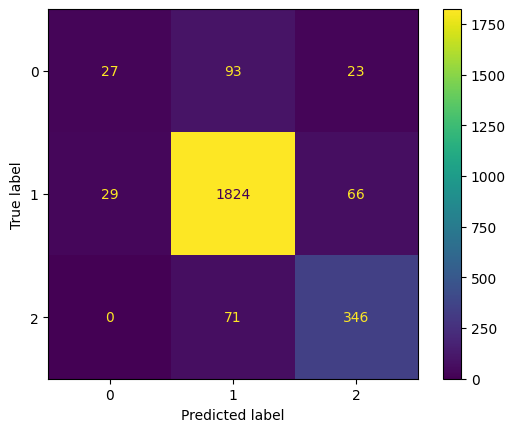

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.48      0.19      0.27       143
           1       0.92      0.95      0.93      1919
           2       0.80      0.83      0.81       417

    accuracy                           0.89      2479
   macro avg       0.73      0.66      0.67      2479
weighted avg       0.87      0.89      0.88      2479



#### SemEval-2019 Dataset


##### Dataset & pre-processing

In [ ]:
semeval_dataset = pd.read_csv('/content/drive/MyDrive/Data science/NLP/Ema/hateval2019_en_train2.csv')

In [ ]:
semeval_dataset

,id,tweet,class,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0
...,...,...,...,...,...
12995,19196,@SamEnvers you unfollowed me? Fuck you pussy,0,0,0
12996,19197,@DanReynolds STFU BITCH! AND YOU GO MAKE SOME ...,1,1,1
12997,19198,"@2beornotbeing Honey, as a fellow white chick,...",0,0,0
12998,19199,I hate bitches who talk about niggaz with kids...,1,0,1


In [ ]:
semeval_dataset = preprocessing(dataset=semeval_dataset, text_column="tweet")

##### Embedding

In [ ]:
semeval_dataset_embedd = tf_idf_withPCA(dataset=semeval_dataset, text_column="tweet")
semeval_bertEmbedding = get_BertEmbedding(dataset=semeval_dataset, text_column="tweet")
semeval_dataset_embedd['bert_embedding'] = semeval_bertEmbedding
semeval_fastTextEmbedding = get_FastTextEmbedding(dataset=semeval_dataset, text_column="tweet")
semeval_dataset_embedd['fastText_embeddings'] = semeval_fastTextEmbedding

In [ ]:
semeval_dataset_embedd.drop(['id', 'TR', 'AG', 'tweet'], axis=1, inplace=True)

In [ ]:
semeval_dataset_embedd['bert_embedding'] = semeval_dataset_embedd.apply(lambda row: tensor_to_list(row), axis=1)

In [ ]:
# Split vectors embeddings in single columns
# BERT
semeval_dataset_embedd[['embeddBert_val_' + str(i) for i in range(len(semeval_dataset_embedd.iloc[0]['bert_embedding']))]] = \
    pd.DataFrame(semeval_dataset_embedd['bert_embedding'].values.tolist(), index= semeval_dataset_embedd.index)

semeval_dataset_embedd.drop(['bert_embedding'], axis=1, inplace=True)

# FASTTEXT
semeval_dataset_embedd[['embedFastText_val_' + str(i) for i in range(len(semeval_dataset_embedd.iloc[0]['fastText_embeddings']))]] = \
    pd.DataFrame(semeval_dataset_embedd['fastText_embeddings'].values.tolist(), index= semeval_dataset_embedd.index)

semeval_dataset_embedd.drop(['fastText_embeddings'], axis=1, inplace=True)

In [ ]:
# Save file, to reuse it
semeval_dataset_embedd.to_pickle('/content/drive/MyDrive/NLP/ema_dataset_embedd')

##### Prediction

In [ ]:
semeval_dataset_embedd = pd.read_pickle('/content/drive/MyDrive/NLP/ema_dataset_embedd')

In [ ]:
X = semeval_dataset_embedd.loc[:, semeval_dataset_embedd.columns != 'class']
y = semeval_dataset_embedd['class']
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, stratify=y_testval, random_state=1234)

In [ ]:
classifier_xgb = XGBClassifier().fit(X_train, y_train)
pred_xgb = classifier_xgb.predict(X_test)
cm = confusion_matrix(y_test, pred_xgb)
accuracy = accuracy_score(y_test, pred_xgb)

In [ ]:
accuracy

0.7253846153846154

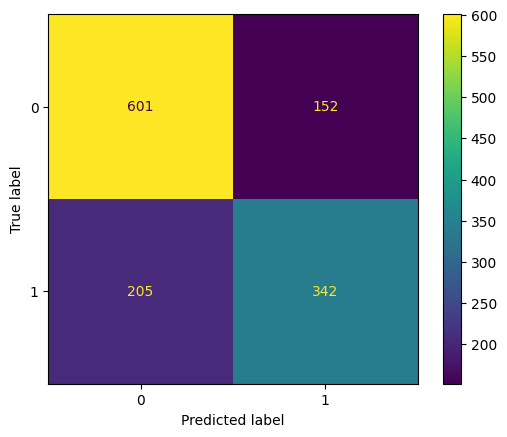

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       753
           1       0.69      0.63      0.66       547

    accuracy                           0.73      1300
   macro avg       0.72      0.71      0.71      1300
weighted avg       0.72      0.73      0.72      1300

